# Import librării folosite

In [ ]:
!pip install gensim


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 112.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompati

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 363.4/363.4 MB 217.1 MB/s eta 0:00:01^C


In [ ]:
!pip install stanza

In [1]:
import pandas as pd
import numpy as np
import re
import random
import os
import time
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
import unicodedata
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
import torch.nn as nn
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import requests
import time
import json
from collections import Counter
from tqdm import tqdm
import shutil
import glob

# Alcatuirea dataframe-urilor

In [2]:
from google.colab import files
uploaded = files.upload()

Saving validation_dialect_labels.txt to validation_dialect_labels.txt
Saving validation_samples.txt to validation_samples.txt
Saving train_samples.txt to train_samples.txt
Saving train_dialect_labels.txt to train_dialect_labels.txt
Saving test_samples.txt to test_samples.txt
Saving test_dialect_labels.txt to test_dialect_labels.txt


In [3]:
def create_df(filename, column1, column2):
    rows = []
    with open(filename, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split("\t") #split o singură dată
            if len(parts) == 2:
                val1, val2 = parts
                rows.append((val1, val2))

    return pd.DataFrame(rows, columns=[column1, column2])

In [4]:
df_train_samples=create_df("train_samples.txt","id","sample")
df_train_labels=create_df("train_dialect_labels.txt","id","label")
df_valid_samples=create_df("validation_samples.txt","id","sample")
df_valid_labels=create_df("validation_dialect_labels.txt","id","label")
df_test_samples=create_df("test_samples.txt","id","sample")
df_test_labels=create_df("test_dialect_labels.txt","id","label")

In [5]:
df_train = pd.merge(df_train_samples, df_train_labels, on='id', how='inner')
df_valid = pd.merge(df_valid_samples, df_valid_labels, on='id', how='inner')
df_test = pd.merge(df_test_samples, df_test_labels, on='id', how='inner')

# Curatarea datelor si distributia lor

In [6]:
def clean_text(text):
    #inlocuim $NE$ cu un placeholder sigur temporar
    text = text.replace('$NE$', 'TOKEN_NE')
    # lowercase
    text = text.lower()
    # eliminam cifre
    text = re.sub(r'\d+', '', text)
    # eliminam semne de punctuație
    text = re.sub(r'[^\w\s]', ' ', text)
    # inlocuim spatiile multiple cu un singur spatiu
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    # restauram tokenul $NE$
    text = text.replace('token_ne', '$NE$')

    return text

In [7]:
df_train['clean_sample'] = df_train['sample'].apply(clean_text)
df_valid['clean_sample'] = df_valid['sample'].apply(clean_text)
df_test['clean_sample'] = df_test['sample'].apply(clean_text)

In [8]:
df_train['label'] = df_train['label'].astype(int)

/tmp/ipython-input-8-2215783464.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='viridis')


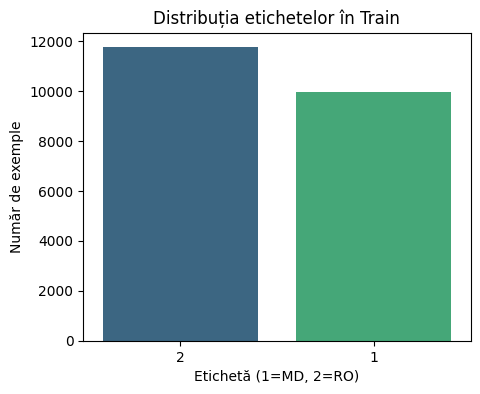

/tmp/ipython-input-8-2215783464.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='viridis')


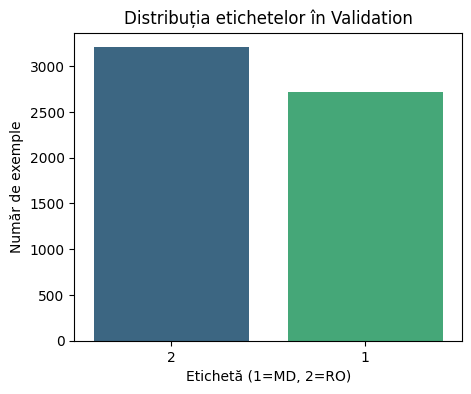

/tmp/ipython-input-8-2215783464.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='viridis')


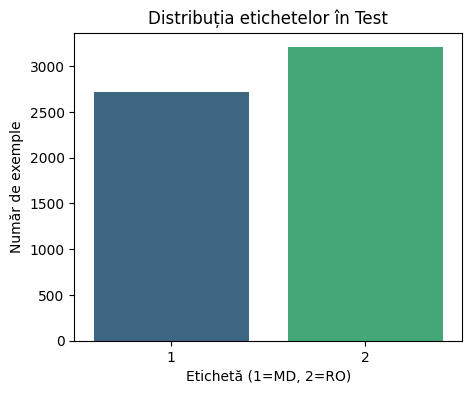

In [ ]:
def plot_distribution(df, name):
    plt.figure(figsize=(5, 4))
    sns.countplot(data=df, x='label', palette='viridis')
    plt.title(f'Distribuția etichetelor în {name}')
    plt.xlabel('Etichetă (1=MD, 2=RO)')
    plt.ylabel('Număr de exemple')
    plt.show()

plot_distribution(df_train, 'Train')
plot_distribution(df_valid, 'Validation')
plot_distribution(df_test, 'Test')

# Analiza subtilitatilor lingvistice

## Analiza influentei rusesti in cele 2 dialecte folosind Fasttext

Observatii
* similaritate mare intre romana si moldoveneasca
* scor negativ de cosine similarity intre romana si rusa
* scor pozitiv, dar mic de cosine similarity intre moldoveneasca si rusa

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving _file_1.txt to _file_1.txt
Saving _file_10.txt to _file_10.txt
Saving _file_11.txt to _file_11.txt
Saving _file_12.txt to _file_12.txt
Saving _file_17.txt to _file_17.txt
Saving _file_18.txt to _file_18.txt
Saving _file_20.txt to _file_20.txt
Saving _file_101.txt to _file_101.txt
Saving _file_103.txt to _file_103.txt
Saving _file_104.txt to _file_104.txt
Saving _file_108.txt to _file_108.txt
Saving _file_110.txt to _file_110.txt
Saving _file_112.txt to _file_112.txt
Saving _file_113.txt to _file_113.txt
Saving _file_116.txt to _file_116.txt
Saving _file_118.txt to _file_118.txt
Saving _file_120.txt to _file_120.txt
Saving _file_121.txt to _file_121.txt
Saving _file_123.txt to _file_123.txt
Saving _file_124.txt to _file_124.txt
Saving _file_126.txt to _file_126.txt
Saving _file_127.txt to _file_127.txt
Saving _file_133.txt to _file_133.txt
Saving _file_134.txt to _file_134.txt
Saving _file_136.txt to _file_136.txt
Saving _file_137.txt to _file_137.txt
Saving _file_139.txt to _fil

In [ ]:
os.makedirs("samples_ru", exist_ok=True)

In [ ]:
folder_destinatie = "/content/samples_ru"
for filepath in glob.glob("/content/*.txt"):
    shutil.move(filepath, folder_destinatie)

In [ ]:
samples_ru = []
folder_path="/content/samples_ru"
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
        with open(os.path.join(folder_path, filename), encoding="utf-8") as f:
            content = f.read()
            samples_ru.append(content)

In [ ]:
tokenized_corpus_ru = []

for sample in samples_ru:
    #t = transliterate_ru(sample)
    cleaned = clean_text(sample)
    tokens = cleaned.split()
    tokenized_corpus_ru.append(tokens)

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ro.300.vec.gz
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz

!gunzip cc.ro.300.vec.gz
!gunzip cc.ru.300.vec.gz


--2025-07-19 10:26:39--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ro.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.96, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1233659733 (1.1G) [binary/octet-stream]
Saving to: ‘cc.ro.300.vec.gz’

cc.ro.300.vec.gz    100%[===================>]   1.15G  91.9MB/s    in 21s     

2025-07-19 10:27:00 (57.3 MB/s) - ‘cc.ro.300.vec.gz’ saved [1233659733/1233659733]

--2025-07-19 10:27:00--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.96, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1306357571 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ru.30

In [ ]:
from gensim.models import KeyedVectors

fasttext_ro = KeyedVectors.load_word2vec_format('cc.ro.300.vec', binary=False)
fasttext_ru = KeyedVectors.load_word2vec_format('cc.ru.300.vec', binary=False)


In [ ]:
def encode_sample_fasttext(sample_tokens, model):
    vectors = []
    for token in sample_tokens:
        if token in model:
            vectors.append(model[token])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)


In [ ]:
#Fixam un seed pentru reproductibilitate
random.seed(42)

samples_ro = df_train[df_train['label']==2]['clean_sample']
samples_md = df_train[df_train['label']==1]['clean_sample']

samples_ro = random.sample(list(samples_ro), 900)
samples_md = random.sample(list(samples_md), 900)

tokenized_ro = [sample.split() for sample in samples_ro]
tokenized_md = [sample.split() for sample in samples_md]

In [ ]:
encoded_samples_ro = [encode_sample_fasttext(tokens, fasttext_ro) for tokens in tokenized_ro]
encoded_samples_md = [encode_sample_fasttext(tokens, fasttext_ro) for tokens in tokenized_md]
encoded_samples_ru = [encode_sample_fasttext(tokens, fasttext_ru) for tokens in tokenized_corpus_ru]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

mean_ro = normalize([np.mean(encoded_samples_ro, axis=0)])[0]
mean_md = normalize([np.mean(encoded_samples_md, axis=0)])[0]
mean_ru = normalize([np.mean(encoded_samples_ru, axis=0)])[0]

sim_ro_md = cosine_similarity([mean_ro], [mean_md])[0][0]
sim_ro_ru = cosine_similarity([mean_ro], [mean_ru])[0][0]
sim_md_ru = cosine_similarity([mean_md], [mean_ru])[0][0]

print(f"Similitudine RO vs MD: {sim_ro_md:.4f}")
print(f"Similitudine RO vs RU: {sim_ro_ru:.4f}")
print(f"Similitudine MD vs RU: {sim_md_ru:.4f}")

Similitudine RO vs MD: 0.9956
Similitudine RO vs RU: -0.0005
Similitudine MD vs RU: 0.0126


## Frecventa litera î

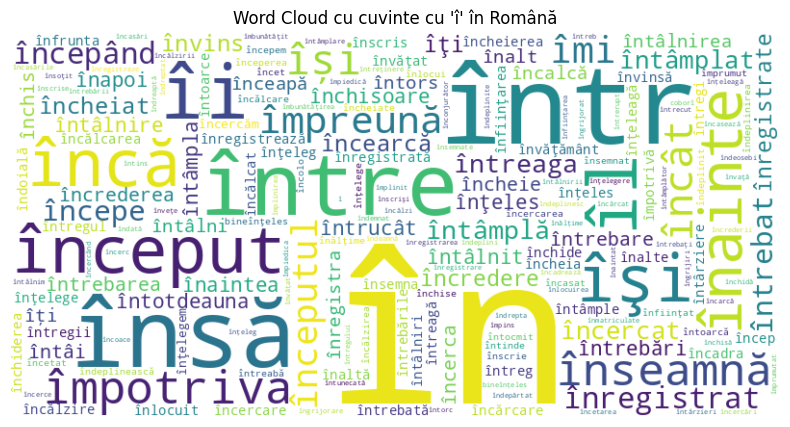

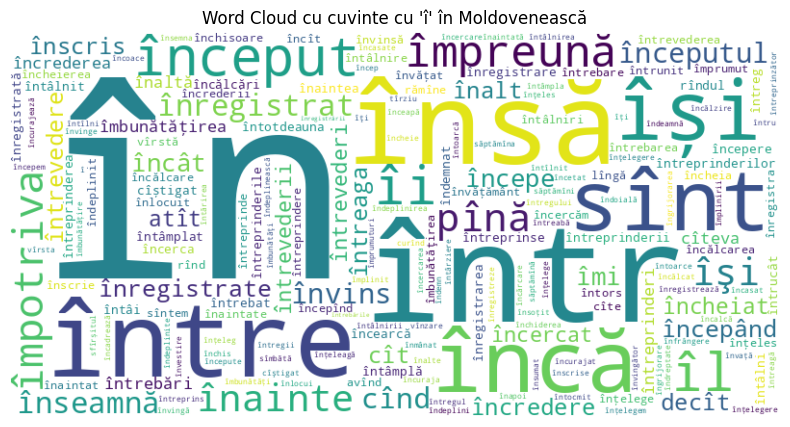

In [ ]:
from wordcloud import WordCloud

def extract_words_with_i(samples):
    words = []
    for sample in samples:
        tokens = re.findall(r'\b\w*\î\w*\b', sample.lower())
        words.extend(tokens)
    return words

samples_ro = df_train[df_train['label']==2]['clean_sample']
samples_md = df_train[df_train['label']==1]['clean_sample']

# Extragere cuvinte cu "î" din ambele dialecte
words_ro = extract_words_with_i(samples_ro)
words_md = extract_words_with_i(samples_md)

#frecvența
freq_ro = Counter(words_ro)
freq_md = Counter(words_md)

# Creare word cloud
def plot_wordcloud(freq_dict, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

plot_wordcloud(freq_ro, "Word Cloud cu cuvinte cu 'î' în Română")
plot_wordcloud(freq_md, "Word Cloud cu cuvinte cu 'î' în Moldovenească")


## Analiza partilor de vorbire

Observații


*   Mai multe substantive în moldoveneasca
*   Mai multe verbe in romana
*   Mai puține VERB, ADV, ADP în moldoveneasca-> formulare mai simplă, poate mai "rigidă"
*   Entropie POS mai mică în MD, mai puțină varietate în structura propozițiilor

In [ ]:
samples_ro = df_train[df_train['label']==2]['clean_sample']
samples_md = df_train[df_train['label']==1]['clean_sample']

In [ ]:
samples_ro = samples_ro.sample(n=4000, random_state=42)
samples_md = samples_md.sample(n=4000, random_state=42)

In [ ]:
! pip install stanza

  Using cached stanza-1.10.1-py3-none-any.whl.metadata (13 kB)
  Using cached emoji-2.14.1-py3-none-any.whl.metadata (5.7 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)

In [ ]:
import stanza

stanza.download('ro')
nlp_ro = stanza.Pipeline(lang='ro', processors='tokenize,pos', use_gpu=True)

def get_pos_tags(text):
    doc = nlp_ro(text)
    return [word.upos for sentence in doc.sentences for word in sentence.words]


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: ro (Romanian) ...


INFO:stanza:Downloaded file to /root/stanza_resources/ro/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: ro (Romanian):
| Processor | Package      |
----------------------------
| tokenize  | rrt          |
| pos       | rrt_nocharlm |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Done loading processors!


In [ ]:
def extract_pos_features(pos_tags):
    counts = Counter(pos_tags)
    total = sum(counts.values())
    if total == 0:
        return {tag: 0.0 for tag in ['NOUN', 'VERB', 'ADJ', 'ADV', 'PRON', 'ADP', 'DET', 'AUX', 'CCONJ', 'SCONJ', 'INTJ', 'NUM', 'PART', 'SYM', 'X', 'PUNCT']} | {'entropy': 0.0}

    probs = np.array([count / total for count in counts.values()])
    entropy = -np.sum(probs * np.log2(probs + 1e-9))

    features = {
        tag: counts[tag] / total for tag in [
            'NOUN', 'VERB', 'ADJ', 'ADV', 'PRON', 'ADP', 'DET', 'AUX', 'CCONJ',
            'SCONJ', 'INTJ', 'NUM', 'PART', 'SYM', 'X', 'PUNCT'
        ]
    }
    features['entropy'] = entropy
    return features


In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()

samples_ro_pos = samples_ro.progress_apply(get_pos_tags)
samples_md_pos = samples_md.progress_apply(get_pos_tags)

samples_ro_feat = samples_ro_pos.progress_apply(extract_pos_features)
samples_md_feat = samples_md_pos.progress_apply(extract_pos_features)

df_pos_ro = pd.DataFrame(samples_ro_feat.tolist())
df_pos_md = pd.DataFrame(samples_md_feat.tolist())


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [ ]:
mean_ro = df_pos_ro.mean()
mean_md = df_pos_md.mean()

comparison_df = pd.DataFrame({'RO': mean_ro, 'MD': mean_md})
comparison_df['Diff'] = comparison_df['MD'] - comparison_df['RO']
comparison_df.sort_values('Diff', ascending=False)


,RO,MD,Diff
NOUN,0.362735,0.392721,0.029986
PRON,0.104012,0.109009,0.004998
CCONJ,0.022673,0.026061,0.003389
ADJ,0.048072,0.050928,0.002855
NUM,0.010915,0.011292,0.000377
SYM,0.000000,0.000000,0.000000
X,0.000000,0.000000,0.000000
INTJ,0.000042,0.000040,-0.000002
PUNCT,0.001999,0.001085,-0.000915
SCONJ,0.012035,0.008846,-0.003189


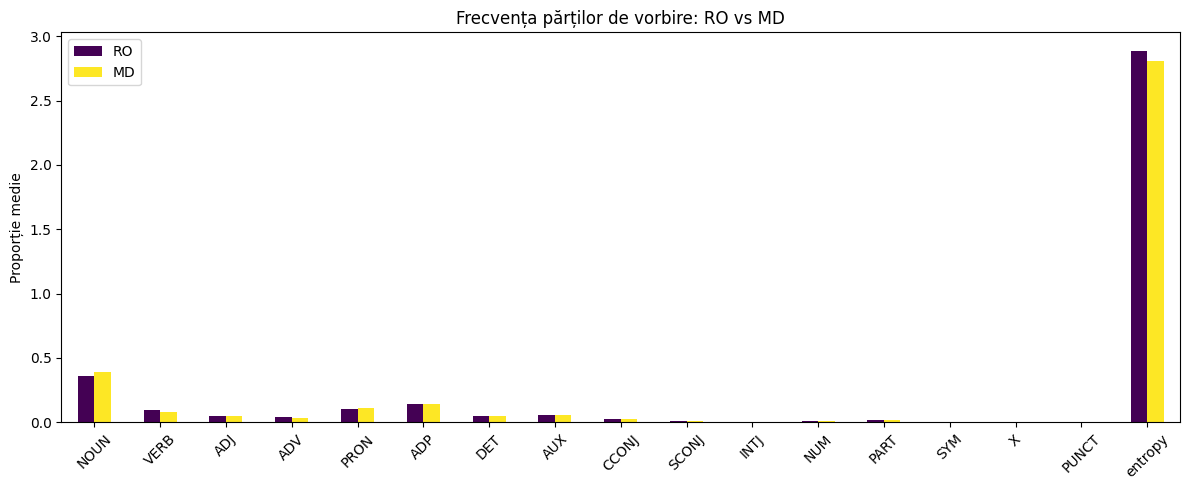

In [ ]:
import matplotlib.pyplot as plt

comparison_df[['RO', 'MD']].plot(kind='bar', figsize=(12, 5), colormap='viridis')
plt.title("Frecvența părților de vorbire: RO vs MD")
plt.ylabel("Proporție medie")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
!python -m spacy download ro_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.5/568.5 MB 392.3 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ro_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Analiza timpurilor verbale

* analiza pe cele 4000 de samples selectate aleator arata ca in romana s-au folosit mai multe verbe la prezent (diferenta de 2300 de instante)
* pare sa existe o mai mare varietate la nivel de verbe in romana

In [ ]:
import spacy

nlp = spacy.load("ro_core_news_lg")

def extract_verb_tenses(text):
    doc = nlp(text)
    tenses = []
    for token in doc:
        if token.pos_ in ['VERB', 'AUX']:
            tense = token.morph.get("Tense")
            if tense:
                tenses.extend(tense)
    return tenses


In [ ]:
from tqdm import tqdm
tqdm.pandas()

ro_tenses = []
md_tenses = []

for sample in tqdm(samples_ro):
    ro_tenses.extend(extract_verb_tenses(sample))

for sample in tqdm(samples_md):
    md_tenses.extend(extract_verb_tenses(sample))

# Frecvențe
ro_tense_dist = Counter(ro_tenses)
md_tense_dist = Counter(md_tenses)


100%|██████████| 4000/4000 [03:33<00:00, 18.75it/s]


In [ ]:

df_tenses = pd.DataFrame({
    'RO': pd.Series(ro_tense_dist),
    'MD': pd.Series(md_tense_dist)
}).fillna(0)

df_tenses['Total'] = df_tenses['RO'] + df_tenses['MD']
df_tenses['Diff_MD_minus_RO'] = df_tenses['MD'] / df_tenses['Total'] - df_tenses['RO'] / df_tenses['Total']
df_tenses.sort_values(by='Diff_MD_minus_RO', ascending=False)


,RO,MD,Total,Diff_MD_minus_RO
Imp,71671,71455,143126,-0.001509
Past,5386,4170,9556,-0.127250
Pres,86812,63647,150459,-0.153962
Pqp,508,225,733,-0.386085


## Frecventa diacriticelor

In [ ]:
diacritice = set("ăîâșțĂÎÂȘȚ")

In [ ]:
def diacritic_ratio(text):
    if len(text.strip()) == 0:
        return 0.0
    total_chars = len(text)
    diacritic_chars = sum(1 for c in text if c in diacritice)
    return diacritic_chars / total_chars

In [ ]:
samples_ro_ratio = samples_ro.apply(diacritic_ratio)
samples_md_ratio = samples_md.apply(diacritic_ratio)
print("RO - Media:", samples_ro_ratio.mean(), "STD:", samples_ro_ratio.std())
print("MD - Media:", samples_md_ratio.mean(), "STD:", samples_md_ratio.std())

RO - Media: 0.03369587488102436 STD: 0.018238126427184767
MD - Media: 0.039532504374516504 STD: 0.011895538285474835


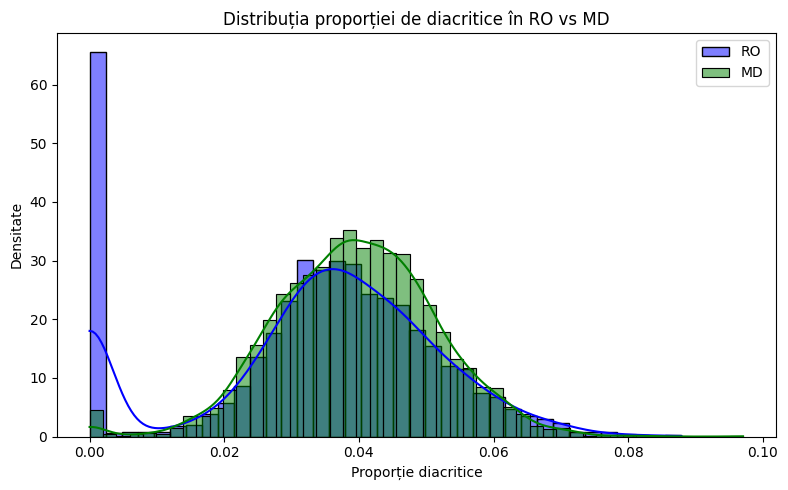

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(samples_ro_ratio, label='RO', color='blue', kde=True, stat='density')
sns.histplot(samples_md_ratio, label='MD', color='green', kde=True, stat='density')
plt.title('Distribuția proporției de diacritice în RO vs MD')
plt.xlabel('Proporție diacritice')
plt.ylabel('Densitate')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
diacritics = ['ă', 'â', 'î', 'ș', 'ț']

def count_diacritics(text, diacritic):
    if not isinstance(text, str):
        return 0
    return text.count(diacritic)

def total_chars(text):
    return len(text) if isinstance(text, str) else 0


def compute_freqs(samples):
    counts = {d: 0 for d in diacritics}
    total_chars_count = 0
    for text in samples:
        total_chars_count += total_chars(text)
        for d in diacritics:
            counts[d] += count_diacritics(text, d)
    # frecvență relativă (raport la total caractere)
    freqs = {d: counts[d]/total_chars_count if total_chars_count > 0 else 0 for d in diacritics}
    return freqs

freqs_ro = compute_freqs(samples_ro)
freqs_md = compute_freqs(samples_md)

print("Frecvențe diacritice RO:")
print(freqs_ro)
print("\nFrecvențe diacritice MD:")
print(freqs_md)

Frecvențe diacritice RO:
{'ă': 0.01892035393301816, 'â': 0.0028877925877596575, 'î': 0.0072274685130953075, 'ș': 0.0024748111357268377, 'ț': 0.0026414399188926705}

Frecvențe diacritice MD:
{'ă': 0.01941010371847038, 'â': 0.0019048412251702334, 'î': 0.008494208234878476, 'ș': 0.00485764737332067, 'ț': 0.005914176021837164}


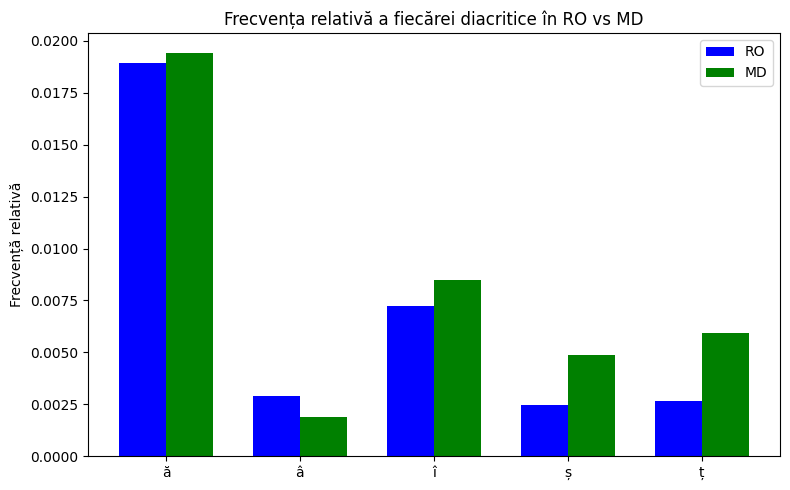

In [ ]:
labels = diacritics
ro_vals = [freqs_ro[d] for d in labels]
md_vals = [freqs_md[d] for d in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, ro_vals, width, label='RO', color='blue')
bars2 = ax.bar(x + width/2, md_vals, width, label='MD', color='green')

ax.set_ylabel('Frecvență relativă')
ax.set_title('Frecvența relativă a fiecărei diacritice în RO vs MD')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.tight_layout()
plt.show()


# VARIANTA 1. Folosirea feature-urilor discriminatorii pentru dialecte, TF-IDF, modelul FOREST pentru clasificare

## Extragerea de features

In [ ]:
def extract_diacritic_features(text):
    features = {}
    total = len(text) if text else 1
    for d in diacritice:
        features[f'freq_{d}'] = text.count(d) / total
    return features


In [ ]:
def extract_letter_features(text):
    text = ''.join(c for c in text.lower() if c.isalpha())
    total_chars = len(text) if len(text) > 0 else 1
    features = {}
    for char in 'aăâbcdefghiîjklmnopqrsștțuvwxyz':
        features[f'freq_{char}'] = text.count(char) / total_chars
    features['â_î_ratio'] = features['freq_â'] / (features['freq_î'] + 0.001)
    features['ă_a_ratio'] = features['freq_ă'] / (features['freq_a'] + 0.001)
    return features

In [ ]:
df_train['pos_tags'] = df_train['clean_sample'].progress_apply(get_pos_tags)
df_train_pos_features = pd.DataFrame(df_train['pos_tags'].progress_apply(extract_pos_features).tolist())

100%|██████████| 21719/21719 [00:00<00:00, 26722.69it/s]


In [ ]:
def compute_similarity_with_russian(sample_text, model_ro, model_ru):
    tokens = clean_text(sample_text).split()
    vec = encode_sample_fasttext(tokens, model_ro)
    if np.linalg.norm(vec) == 0:
        return 0.0
    vec_norm = vec / np.linalg.norm(vec)
    return cosine_similarity([vec_norm], [mean_ru])[0][0]

df_train['sim_rus'] = df_train['clean_sample'].progress_apply(lambda x: compute_similarity_with_russian(x, fasttext_ro, fasttext_ru))

100%|██████████| 21719/21719 [00:35<00:00, 618.15it/s]


In [ ]:
from google.colab import files

# Salvare ca CSV
df_train.to_csv("df_train.csv", index=False)

# Descărcare în browser
files.download("df_train.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Combinare features

TF-IDF

In [ ]:
nltk.download('stopwords', halt_on_error=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
romanian_stopwords = stopwords.words('romanian')
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(4, 6),
                             max_features=15000, stop_words=romanian_stopwords)

Train features

In [ ]:
from scipy.sparse import hstack

print("EXTRAGERE FEATURES TRAIN...")
X_train_tfidf = vectorizer.fit_transform(df_train['clean_sample'])

letter_features_train = pd.DataFrame(df_train['clean_sample'].apply(extract_letter_features).tolist())
diacritic_features_train = pd.DataFrame(df_train['clean_sample'].apply(extract_diacritic_features).tolist())
df_train['pos_tags'] = df_train['clean_sample'].progress_apply(get_pos_tags)
pos_features_train = pd.DataFrame(df_train['pos_tags'].progress_apply(extract_pos_features).tolist())
df_train['sim_rus'] = df_train['clean_sample'].progress_apply(lambda x: compute_similarity_with_russian(x, fasttext_ro, mean_ru))

sim_feat_train = df_train['sim_rus'].values.reshape(-1, 1)
X_train_dense = np.hstack([letter_features_train.values,
                           diacritic_features_train.values,
                           pos_features_train.values,
                           sim_feat_train])
X_train_combined = hstack([X_train_tfidf, X_train_dense])
y_train = df_train['label']

EXTRAGERE FEATURES TRAIN...


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:539: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(
100%|██████████| 21719/21719 [00:35<00:00, 617.32it/s]


Validation features

In [ ]:
X_valid_tfidf = vectorizer.transform(df_valid['clean_sample'])

letter_features_valid = pd.DataFrame(df_valid['clean_sample'].apply(extract_letter_features).tolist())
diacritic_features_valid = pd.DataFrame(df_valid['clean_sample'].apply(extract_diacritic_features).tolist())
df_valid['pos_tags'] = df_valid['clean_sample'].progress_apply(get_pos_tags)
pos_features_valid = pd.DataFrame(df_valid['pos_tags'].progress_apply(extract_pos_features).tolist())
df_valid['sim_rus'] = df_valid['clean_sample'].progress_apply(lambda x: compute_similarity_with_russian(x, fasttext_ro, mean_ru))

sim_feat_valid = df_valid['sim_rus'].values.reshape(-1, 1)
X_valid_dense = np.hstack([letter_features_valid.values,
                           diacritic_features_valid.values,
                           pos_features_valid.values,
                           sim_feat_valid])
X_valid_combined = hstack([X_valid_tfidf, X_valid_dense])
y_valid = df_valid['label']

100%|██████████| 5921/5921 [00:10<00:00, 587.78it/s]


## Antrenarea modelului

In [ ]:
print("ANTRENARE MODEL...")
rf_model = RandomForestClassifier(n_estimators=200, max_depth=30, random_state=42)
rf_model.fit(X_train_combined, y_train)

ANTRENARE MODEL...


RandomForestClassifier(max_depth=30, n_estimators=200, random_state=42)

## Eval Validare

In [ ]:
y_valid = df_valid['label'].astype(int)

In [ ]:
print("EVALUARE VALIDATION:")
y_pred_valid = rf_model.predict(X_valid_combined)
print("Accuracy:", accuracy_score(y_valid, y_pred_valid))
print(classification_report(y_valid, y_pred_valid))

EVALUARE VALIDATION:
Accuracy: 0.8832967404154703
              precision    recall  f1-score   support

           1       0.92      0.82      0.87      2716
           2       0.86      0.94      0.90      3205

    accuracy                           0.88      5921
   macro avg       0.89      0.88      0.88      5921
weighted avg       0.89      0.88      0.88      5921



Test Features

In [ ]:
print("EXTRAGERE FEATURES TEST...")
X_test_tfidf = vectorizer.transform(df_test['clean_sample'])

letter_features_test = pd.DataFrame(df_test['clean_sample'].apply(extract_letter_features).tolist())
diacritic_features_test = pd.DataFrame(df_test['clean_sample'].apply(extract_diacritic_features).tolist())
df_test['pos_tags'] = df_test['clean_sample'].progress_apply(get_pos_tags)
pos_features_test = pd.DataFrame(df_test['pos_tags'].progress_apply(extract_pos_features).tolist())
df_test['sim_rus'] = df_test['clean_sample'].progress_apply(lambda x: compute_similarity_with_russian(x, fasttext_ro, mean_ru))

sim_feat_test = df_test['sim_rus'].values.reshape(-1, 1)
X_test_dense = np.hstack([letter_features_test.values,
                          diacritic_features_test.values,
                          pos_features_test.values,
                          sim_feat_test])
X_test_combined = hstack([X_test_tfidf, X_test_dense])
y_test = df_test['label']

EXTRAGERE FEATURES TEST...


100%|██████████| 5924/5924 [00:09<00:00, 602.78it/s]


## Evaluare Test

In [ ]:
y_test = df_test['label'].astype(int)

In [ ]:
print("EVALUARE TEST:")
y_pred_test = rf_model.predict(X_test_combined)
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

EVALUARE TEST:
Accuracy: 0.8843686698176908
              precision    recall  f1-score   support

           1       0.91      0.83      0.87      2719
           2       0.87      0.93      0.90      3205

    accuracy                           0.88      5924
   macro avg       0.89      0.88      0.88      5924
weighted avg       0.89      0.88      0.88      5924



## Vizualizare rezultate grafic

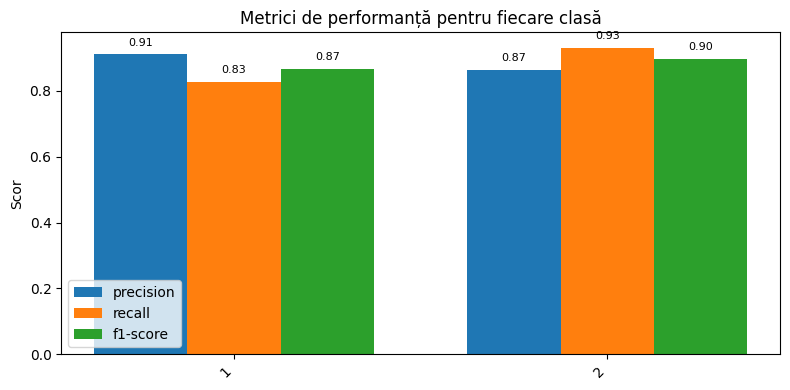

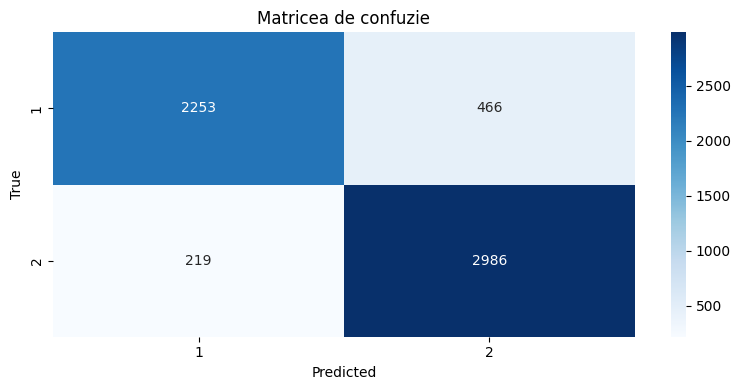

In [ ]:
# 1. Creare grafic pentru raportul de clasificare
def plot_classification_report(y_test, y_pred_test):
    report = classification_report(y_test, y_pred_test, output_dict=True)

    df_report = pd.DataFrame(report).transpose()
    df_plot = df_report.iloc[:-3].copy()
    metrics_to_plot = ['precision', 'recall', 'f1-score']
    plt.figure(figsize=(8, 4))
    ax = plt.subplot(111)

    x = np.arange(len(df_plot.index))
    width = 0.25

    for i, metric in enumerate(metrics_to_plot):
        ax.bar(x + i*width, df_plot[metric], width, label=metric)

    ax.set_ylabel('Scor')
    ax.set_title('Metrici de performanță pentru fiecare clasă')
    ax.set_xticks(x + width)
    ax.set_xticklabels(df_plot.index, rotation=45, ha='right')
    ax.legend()

    for i, metric in enumerate(metrics_to_plot):
        for j, value in enumerate(df_plot[metric]):
            ax.text(j + i*width, value + 0.02, f'{value:.2f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig('raport_clasificare.png')
    plt.show()

# 2. Creare matrice de confuzie
def plot_confusion_matrix(y_test, y_pred_test):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_test, y_pred_test)
    classes = np.unique(np.concatenate((y_test, y_pred_test)))

    plt.figure(figsize=(8, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Matricea de confuzie')
    plt.tight_layout()
    plt.savefig('matrice_confuzie.png')
    plt.show()


# Afișează graficele
plot_classification_report(y_test, y_pred_test)
plot_confusion_matrix(y_test, y_pred_test)

## Importanța feature-urilor

In [ ]:
# 1. Nume TF-IDF
tfidf_feature_names = vectorizer.get_feature_names_out()

# 2. Nume dense (în ordinea concatenării)
letter_names = list(letter_features_train.columns)
diacritic_names = list(diacritic_features_train.columns)
pos_names = list(pos_features_train.columns)
sim_names = ['sim_rus']

# 3. Concatenăm totul
all_feature_names = list(tfidf_feature_names) + letter_names + diacritic_names + pos_names + sim_names


In [ ]:
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
})

# Sortează descrescător
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)


/tmp/ipython-input-60-2796460199.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')


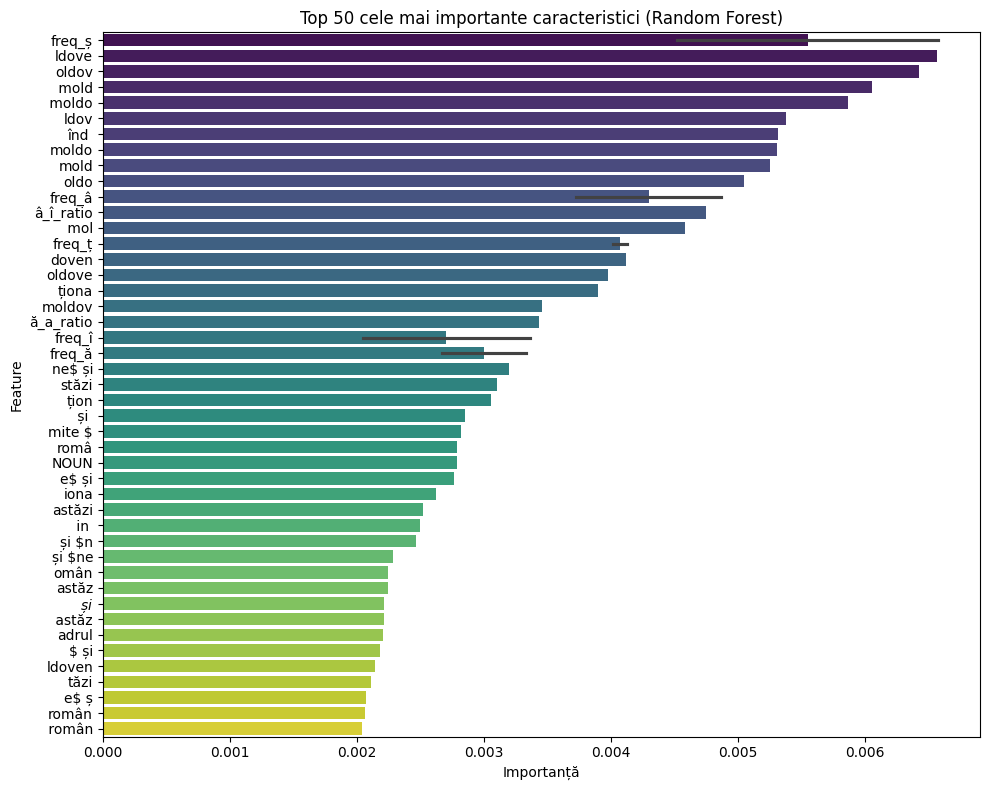

In [ ]:
top_n = 50  # Poți modifica după nevoie
top_features = feature_importance_df.head(top_n)

plt.figure(figsize=(10, 8))
sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
plt.title(f"Top {top_n} cele mai importante caracteristici (Random Forest)")
plt.xlabel("Importanță")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# VARIANTA 2. Fine-tunare de model pre-antrenat RoBERT

### Inițializarea modelului RoBERT și tokenziarea datelor de antrenare și validare

In [9]:
model_name = "readerbench/RoBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

train_texts=df_train["clean_sample"].tolist()
train_labels=df_train["label"].tolist()
val_texts=df_valid["clean_sample"].tolist()
val_labels=df_valid["label"].tolist()
train_labels = [int(label) for label in df_train["label"].tolist()]
val_labels = [int(label) for label in df_valid["label"].tolist()]

train_encodings = tokenizer(
    train_texts, padding=True, truncation=True, max_length=128, return_tensors="pt"
)
train_encodings['labels'] = torch.tensor(train_labels)

val_encodings = tokenizer(
    val_texts, padding=True, truncation=True, max_length=128, return_tensors="pt"
)

val_encodings['labels'] = torch.tensor(val_labels)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/468 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/463M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at readerbench/RoBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/463M [00:00<?, ?B/s]

### Crearea dataset-ului de antrenare și validare

In [10]:
class RomanianDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings['input_ids'])

train_dataset = RomanianDataset(train_encodings)
val_dataset = RomanianDataset(val_encodings)

### Funcția pentru calcularea acurateței

In [11]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

### Inițializarea argumentelor de antrenare și antrenare modelului

In [12]:
os.environ["WANDB_DISABLED"] = "true"
loss_fct = nn.CrossEntropyLoss(ignore_index=0)

training_args_dialect = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    num_train_epochs=5,
    logging_dir="./logs",
    label_smoothing_factor=0.0,


    logging_strategy="epoch",
    logging_steps=100,
    report_to="none",
    load_best_model_at_end=False,
    metric_for_best_model="accuracy"
)

trainer_dialect = Trainer(
    model=model,
    args=training_args_dialect,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

train_results_dialect = trainer_dialect.train()

print(f"Training Loss: {train_results_dialect.training_loss:.4f}")
print("Training Metrics:")
print(train_results_dialect.metrics)

Step,Training Loss
1358,0.266500
2716,0.139900
4074,0.075400
5432,0.026100
6790,0.009100


Training Loss: 0.1034
Training Metrics:
{'train_runtime': 3620.9725, 'train_samples_per_second': 29.991, 'train_steps_per_second': 1.875, 'total_flos': 7143200399543040.0, 'train_loss': 0.10341455392177397, 'epoch': 5.0}


### Codificarea datelor de test, obținerea predicțiilor și evaluarea rezultatelor

In [15]:
test_texts = df_test["clean_sample"].tolist()
test_labels = [int(label) for label in df_test["label"].tolist()]

# Codificarea datelor de test
test_encodings = tokenizer(
    test_texts, padding=True, truncation=True, max_length=128, return_tensors="pt"
)

# Adăugăm label-urile la datele de test pentru a evalua predicțiile
test_dataset_with_labels = RomanianDataset({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': torch.tensor(test_labels)
})

# Evaluare cu metrici
test_results = trainer_dialect.evaluate(test_dataset_with_labels)
print("Test metrics:", test_results)

# Obținerea predicțiilor
predictions_dialect = trainer_dialect.predict(test_dataset_with_labels)
predicted_classes_dialect = torch.argmax(torch.tensor(predictions_dialect.predictions), dim=1)

# Calcularea matricei de confuzie și a raportului de clasificare
conf_matrix = confusion_matrix(test_labels, predicted_classes_dialect)
class_report = classification_report(test_labels, predicted_classes_dialect)
accuracy = accuracy_score(test_labels, predicted_classes_dialect)

print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Salvarea modelului fine-tunat
model.save_pretrained("./romanian_dialect_model")
tokenizer.save_pretrained("./romanian_dialect_model")

Test metrics: {'eval_loss': 0.3569035530090332, 'eval_accuracy': 0.9473328831870358, 'eval_runtime': 44.4389, 'eval_samples_per_second': 133.307, 'eval_steps_per_second': 16.675, 'epoch': 5.0}
Accuracy: 0.9473

Confusion Matrix:
[[2555  164]
 [ 148 3057]]

Classification Report:
              precision    recall  f1-score   support

           1       0.95      0.94      0.94      2719
           2       0.95      0.95      0.95      3205

    accuracy                           0.95      5924
   macro avg       0.95      0.95      0.95      5924
weighted avg       0.95      0.95      0.95      5924



('./romanian_dialect_model/tokenizer_config.json',
 './romanian_dialect_model/special_tokens_map.json',
 './romanian_dialect_model/vocab.txt',
 './romanian_dialect_model/added_tokens.json',
 './romanian_dialect_model/tokenizer.json')

### Vizualizarea rezultatelor

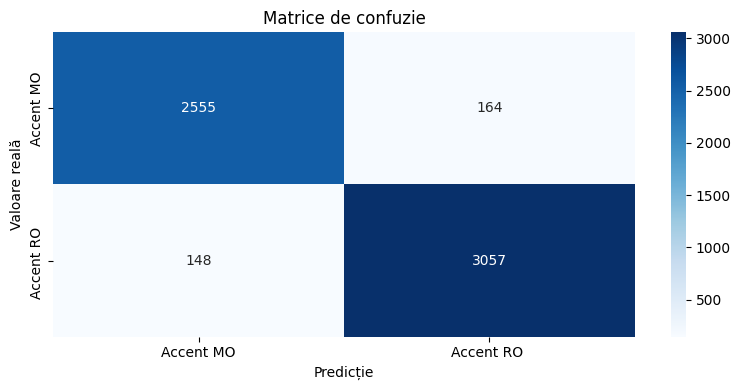

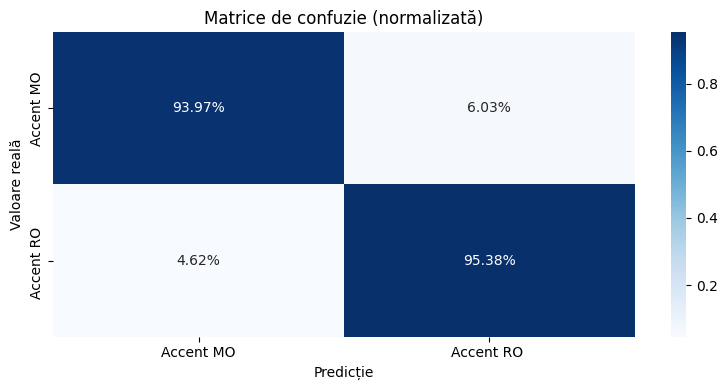

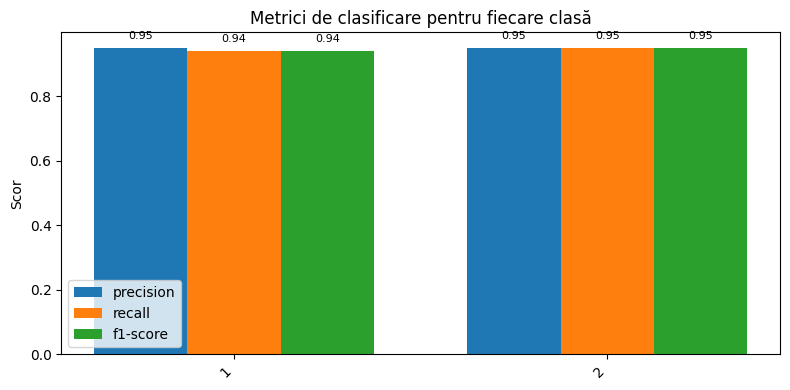

In [18]:
def plot_confusion_matrix(conf_matrix, class_names=None):
    if class_names is None:
        class_names = [f'Clasa {i}' for i in range(len(conf_matrix))]

    plt.figure(figsize=(8, 4))

    conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)

    plt.xlabel('Predicție')
    plt.ylabel('Valoare reală')
    plt.title('Matrice de confuzie')

    plt.tight_layout()
    plt.savefig('bert_confusion_matrix.png')
    plt.show()

    plt.figure(figsize=(8, 4))
    ax = sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicție')
    plt.ylabel('Valoare reală')
    plt.title('Matrice de confuzie (normalizată)')

    plt.tight_layout()
    plt.savefig('bert_confusion_matrix_normalized.png')
    plt.show()



def plot_classification_metrics(class_report):
    if isinstance(class_report, str):
        lines = class_report.split('\n')
        classes = []
        data = []

        for line in lines[2:-5]:
            if not line:
                continue
            row_data = line.strip().split()
            if len(row_data) < 5:
                continue

            class_name = row_data[0]
            precision = float(row_data[1])
            recall = float(row_data[2])
            f1 = float(row_data[3])

            classes.append(class_name)
            data.append([precision, recall, f1])

        df_report = pd.DataFrame(data, index=classes, columns=['precision', 'recall', 'f1-score'])
    else:
        df_report = pd.DataFrame(class_report).transpose()
        df_report = df_report.iloc[:-3]

    metrics_to_plot = ['precision', 'recall', 'f1-score']
    df_plot = df_report[metrics_to_plot]

    plt.figure(figsize=(8, 4))
    ax = plt.subplot(111)

    x = np.arange(len(df_plot.index))
    width = 0.25

    for i, metric in enumerate(metrics_to_plot):
        ax.bar(x + i*width, df_plot[metric], width, label=metric)

    ax.set_ylabel('Scor')
    ax.set_title('Metrici de clasificare pentru fiecare clasă')
    ax.set_xticks(x + width)
    ax.set_xticklabels(df_plot.index, rotation=45, ha='right')
    ax.legend()

    for i, metric in enumerate(metrics_to_plot):
        for j, value in enumerate(df_plot[metric]):
            ax.text(j + i*width, value + 0.02, f'{value:.2f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig('bert_classification_metrics.png')
    plt.show()


class_names = ['Accent MO', 'Accent RO ']

plot_confusion_matrix(conf_matrix, class_names)
plot_classification_metrics(class_report)